In [4]:
import glob
import cv2

In [5]:
X_train = []
y_train = []
image_list =[]
labels = ['green','nolight','red','yellow']
for color in range(len(labels)):
    for i in glob.glob("/home/workspace/dataset/data/real_training_data/"+labels[color]+"/*.jpg"):
        img = cv2.imread(i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128,128))
        X_train.append(img)
        y_train.append(color)
    for i in glob.glob("/home/workspace/dataset/data/sim_training_data/sim_data_capture/"+labels[color]+"/*.jpg"):
        img = cv2.imread(i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128,128))
        X_train.append(img)
        y_train.append(color)
    image_list += glob.glob("/home/workspace/dataset/data/real_training_data/"+labels[color]+"/*.jpg")   
    image_list += glob.glob("/home/workspace/dataset/data/sim_training_data/sim_data_capture/"+labels[color]+"/*.jpg")

In [6]:
print len(X_train)
print len(y_train)
print len(image_list)

985
985
985


In [4]:
import random


0


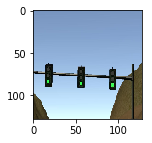

In [5]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(2,2))
plt.imshow(image)
print(y_train[index])

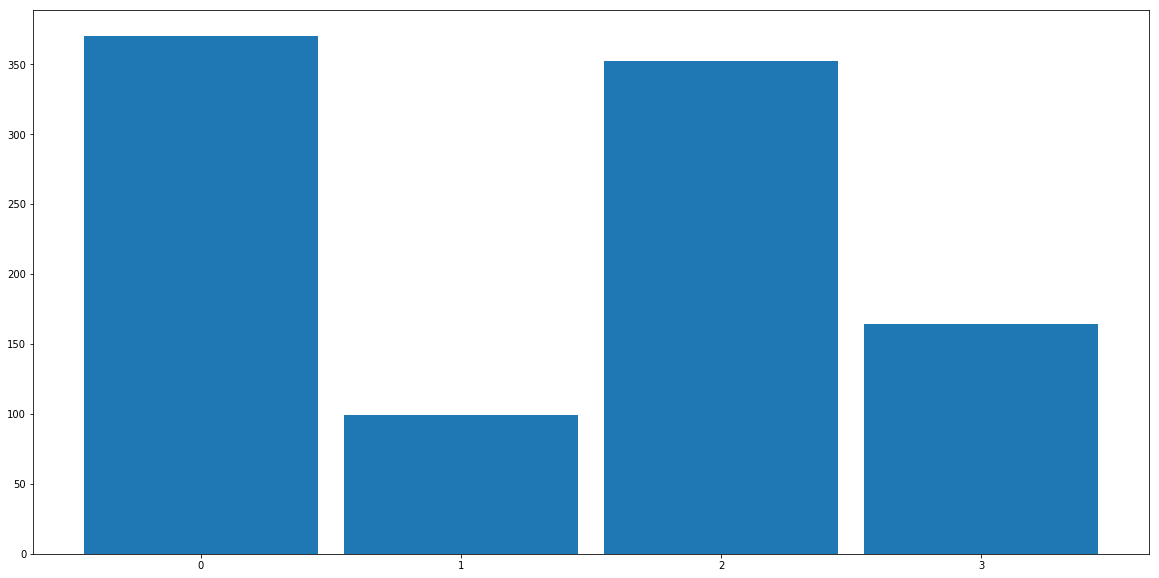

In [11]:
#Plotting Hitogram to get number of images in each class
n_classes = 4
import numpy as np
plt.figure(figsize=(20,10))
plt.xticks( np.arange(n_classes) )
plt.hist(y_train,rwidth=0.9,bins=np.arange(n_classes+1)-0.5)


plt.show()

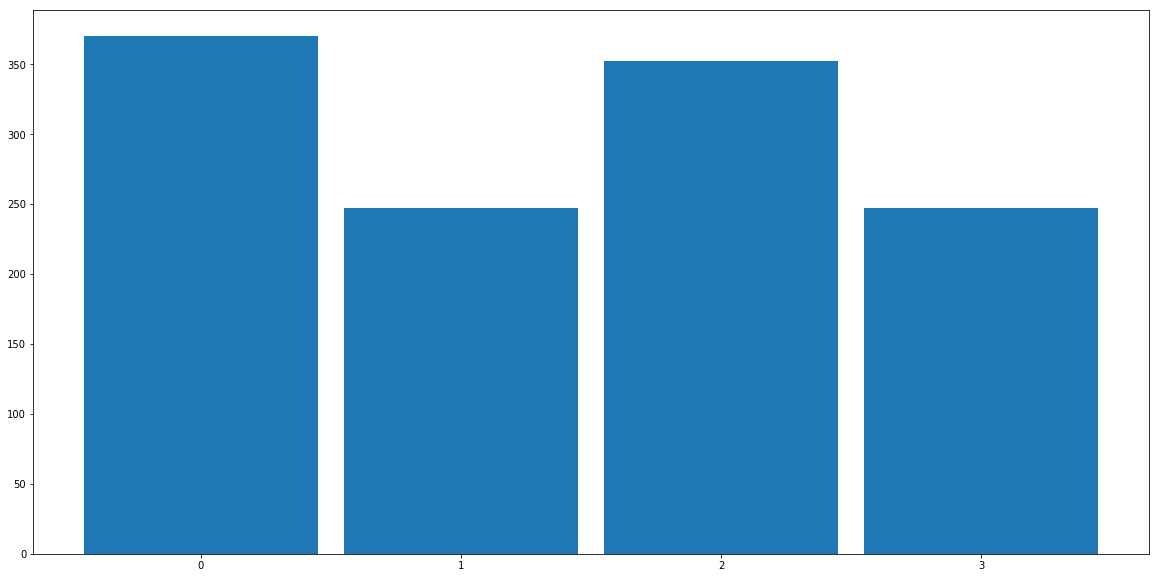

In [12]:
#Augmenting images to fill in classes with less images

X_aug=X_train
y_aug=y_train
mean=np.ceil(len(y_train)/n_classes)
new_images=[]
new_labels=[]
unique, counts = np.unique(y_train, return_counts=True)
dict_y=dict(zip(unique, counts))
for i in range(n_classes):
    count=dict_y[i]
    indices = [j for j, x in enumerate(y_aug) if x == i]
    while count<=mean:
        rand_val=np.random.randint(0, len(indices)-1)
        rand_angle=np.random.randint(0, 10)
        image=X_aug[indices[rand_val]]
        rows,cols = image.shape[0],image.shape[1]
        M = cv2.getRotationMatrix2D((cols/2,rows/2),rand_angle,1)
        dst = cv2.warpAffine(image,M,(cols,rows))
        new_images.append(dst)
        count+=1
        new_labels.append(i)

new_images = np.asarray(new_images)
new_labels = np.asarray(new_labels)
X_aug=np.concatenate((X_aug,new_images))
y_aug=np.concatenate((y_aug,new_labels))

#Plotting Hitogram to get number of images in each class
plt.figure(figsize=(20,10))
plt.xticks( np.arange(n_classes) )
plt.hist(y_aug,rwidth=0.9,bins=np.arange(n_classes+1)-0.5)


plt.show()
X_train=X_aug
y_train=y_aug


In [13]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
from tensorflow.contrib.layers import flatten

def traffic_sign_model(x,keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
        
    # Layer 1: Convolutional. Input = 128x128x3. Output = 124x124x6.
    w1=tf.Variable(tf.truncated_normal((5,5,3,6),mu,sigma,name="w1"))
    b1=tf.Variable(tf.zeros(6),name="b1")
    conv1=tf.nn.conv2d(x,w1,[1,1,1,1],'VALID')
    conv1=tf.nn.bias_add(conv1,b1)

    # Activation.
    conv1=tf.nn.relu(conv1)

    # Pooling. Input = 124x124x6. Output = 62x62x6.
    conv1=tf.nn.max_pool(conv1,[1,2,2,1],[1,2,2,1],'VALID')

    # Layer 2: Convolutional. Input = 62x62x6. Output = 60x60x16.
    w2=tf.Variable(tf.truncated_normal((3,3,6,16),mu,sigma,name="w2"))
    b2=tf.Variable(tf.zeros(16),name="b2")
    conv2=tf.nn.conv2d(conv1,w2,[1,1,1,1],'VALID')
    conv2=tf.nn.bias_add(conv2,b2)
    
    # Activation.
    conv2=tf.nn.relu(conv2)

    # Pooling. Input = 60x60x16. Output = 30x30x16.
    conv2=tf.nn.max_pool(conv2,[1,2,2,1],[1,2,2,1],'VALID')
    
    # Flatten. Input = 30x30x16. Output = 14400.
    conv2=flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 14400. Output = 640.
    w_fc1=tf.Variable(tf.truncated_normal((14400,640),mean=mu,stddev=sigma),name="w_fc1")
    b_fc1=tf.Variable(tf.zeros(640),name="b_fc1")
    out_fc1=tf.add(tf.matmul(conv2,w_fc1),b_fc1)
    
    # Activation.
    out_fc1=tf.nn.relu(out_fc1)
    
    #DropOut
    out_fc1=tf.nn.dropout(out_fc1,keep_prob)

    # Layer 4: Fully Connected. Input = 640. Output = 120.
    w_fc2=tf.Variable(tf.truncated_normal((640,120),mean=mu,stddev=sigma),name="w_fc2")
    b_fc2=tf.Variable(tf.zeros(120),name="b_fc2")
    out_fc2=tf.add(tf.matmul(out_fc1,w_fc2),b_fc2)
    
    # Activation.
    out_fc2=tf.nn.relu(out_fc2)

    # Layer 5: Fully Connected. Input = 120. Output = 16.
    w_fc3=tf.Variable(tf.truncated_normal((120,16),mean=mu,stddev=sigma),name="w_fc3")
    b_fc3=tf.Variable(tf.zeros(16),name="b_fc3")
    out_fc3=tf.add(tf.matmul(out_fc2,w_fc3),b_fc3)
    
    # Activation.
    out_fc3=tf.nn.relu(out_fc3)
    
    # Layer 5: Fully Connected. Input = 16. Output = 4.
    w_fc4=tf.Variable(tf.truncated_normal((16,4),mean=mu,stddev=sigma),name="w_fc4")
    b_fc4=tf.Variable(tf.zeros(4),name="b_fc4")
    logits=tf.add(tf.matmul(out_fc3,w_fc4),b_fc4,name="logits")
    
    return logits

In [14]:
# Modelling
import tensorflow as tf

EPOCHS = 90
BATCH_SIZE = 64

#placeholders for the inputs and one hot encoding done for the given labels
x = tf.placeholder(tf.float32, (None, 128, 128, 3),name='input')
y = tf.placeholder(tf.int32, (None),name='labels_y')
one_hot_y = tf.one_hot(y, 4)

#learning rate
rate = 0.001

keep_prob=tf.placeholder(tf.float32,name='keep_prob')

logits = traffic_sign_model(x,keep_prob)

#Loss calculation
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)

#Gradient Descent
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
prediction = tf.argmax(logits, 1, name='prediction')

correct_prediction = tf.equal(prediction, tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,keep_prob:1.})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

print('Model created')

Model created


Training...
()
EPOCH 10 ...
Validation Accuracy = 0.679
()
EPOCH 20 ...
Validation Accuracy = 0.798
()
EPOCH 30 ...
Validation Accuracy = 0.816
()
EPOCH 40 ...
Validation Accuracy = 0.886
()
EPOCH 50 ...
Validation Accuracy = 0.998
()
EPOCH 60 ...
Validation Accuracy = 0.998
()
EPOCH 70 ...
Validation Accuracy = 0.998
()
EPOCH 80 ...
Validation Accuracy = 0.998
()
EPOCH 90 ...
Validation Accuracy = 0.998
()
Final Validation Accuracy = 0.998
Final Training Accuracy = 0.998
()
Model saved in path: model.ckpt


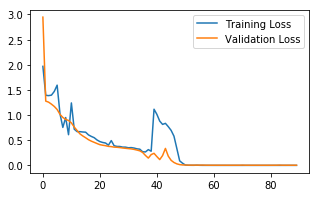

In [17]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

loss_values_train=[]
loss_values_valid=[]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    
    for i in range(EPOCHS):
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,keep_prob:0.5})
            
        loss_values_train.append(sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y,keep_prob:1.}))
        loss_values_valid.append(sess.run(loss_operation, feed_dict={x: X_train, y: y_train,keep_prob:1.}))
        
        if((i+1)%10==0):
            validation_accuracy = evaluate(X_train, y_train)
            print("EPOCH {} ...".format(i+1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()
            
    training_accuracy = evaluate(X_train, y_train)
    print("Final Validation Accuracy = {:.3f}".format(validation_accuracy))
    print("Final Training Accuracy = {:.3f}".format(training_accuracy))
    print()

    saver.save(sess, 'traffic_data.ckpt')
    save_path = saver.save(sess, "model.ckpt")
    print("Model saved in path: %s" % save_path)
    
    plt.figure(figsize=(5,3))
    plt.plot(loss_values_train,label="Training Loss")
    plt.plot(loss_values_valid,label="Validation Loss")
    plt.legend()

    plt.show()

In [100]:
#testing the model

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_train, y_train)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

ValueError: Can't load save_path when it is None.

In [109]:
tf.reset_default_graph()

with tf.Session() as sess:
    saver = tf.train.import_meta_graph('model.ckpt.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    print(sess.graph.get_operations())

    print("Model restored.")
    

INFO:tensorflow:Restoring parameters from ./model.ckpt
[<tf.Operation 'Placeholder' type=Placeholder>, <tf.Operation 'Placeholder_1' type=Placeholder>, <tf.Operation 'one_hot/on_value' type=Const>, <tf.Operation 'one_hot/off_value' type=Const>, <tf.Operation 'one_hot/depth' type=Const>, <tf.Operation 'one_hot' type=OneHot>, <tf.Operation 'Placeholder_2' type=Placeholder>, <tf.Operation 'w1/shape' type=Const>, <tf.Operation 'w1/mean' type=Const>, <tf.Operation 'w1/stddev' type=Const>, <tf.Operation 'w1/TruncatedNormal' type=TruncatedNormal>, <tf.Operation 'w1/mul' type=Mul>, <tf.Operation 'w1' type=Add>, <tf.Operation 'Variable' type=VariableV2>, <tf.Operation 'Variable/Assign' type=Assign>, <tf.Operation 'Variable/read' type=Identity>, <tf.Operation 'zeros' type=Const>, <tf.Operation 'b1' type=VariableV2>, <tf.Operation 'b1/Assign' type=Assign>, <tf.Operation 'b1/read' type=Identity>, <tf.Operation 'Conv2D' type=Conv2D>, <tf.Operation 'BiasAdd' type=BiasAdd>, <tf.Operation 'Relu' type=

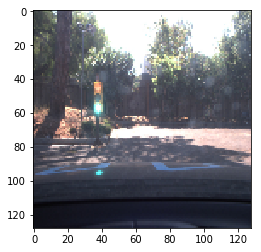

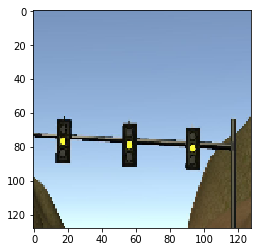

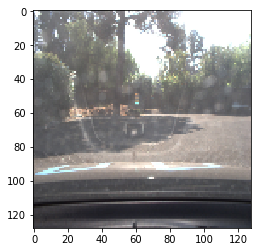

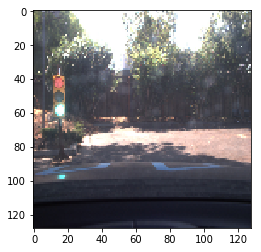

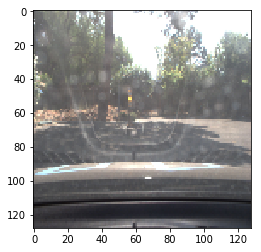

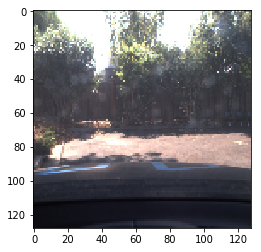

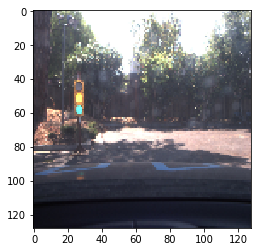

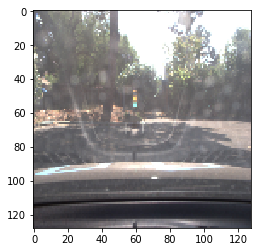

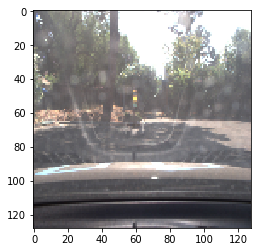

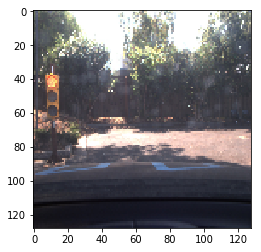

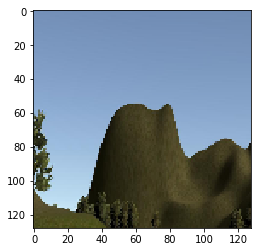

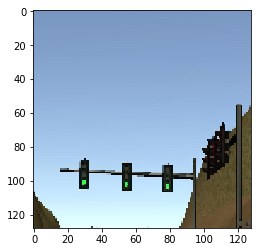

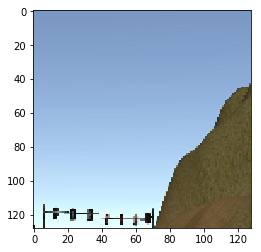

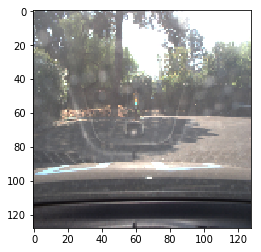

In [21]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os
rows=1
columns=5
i=1

images=[]

for filename in os.listdir('/home/workspace/dataset/data/test/'):
    img = cv2.imread(os.path.join('/home/workspace/dataset/data/test/',filename))
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)
    plt.imshow(img)
    plt.show()
    i+=1

plt.show()

In [19]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.


#Preprocessing
for i in range(0,len(images)):
    images[i] = cv2.resize(images[i], (128,128))
    images[i]=np.reshape(images[i],(images[i].shape[0],images[i].shape[1],3))
    
#Setting labels for the input images
y_input_images=[0,3,0,0,3,1,0,0,3,2,1,0,2,0]


In [20]:
# Running the predictions
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    predicted_out=sess.run(correct_prediction,feed_dict={x: images,y:y_input_images,keep_prob:1.})
    
    for i in range(0,len(predicted_out)):
        print('Figure',i+1,':', predicted_out[i],'Prediction')


INFO:tensorflow:Restoring parameters from ./model.ckpt
('Figure', 1, ':', True, 'Prediction')
('Figure', 2, ':', True, 'Prediction')
('Figure', 3, ':', True, 'Prediction')
('Figure', 4, ':', False, 'Prediction')
('Figure', 5, ':', True, 'Prediction')
('Figure', 6, ':', True, 'Prediction')
('Figure', 7, ':', False, 'Prediction')
('Figure', 8, ':', False, 'Prediction')
('Figure', 9, ':', True, 'Prediction')
('Figure', 10, ':', True, 'Prediction')
('Figure', 11, ':', True, 'Prediction')
('Figure', 12, ':', True, 'Prediction')
('Figure', 13, ':', True, 'Prediction')
('Figure', 14, ':', True, 'Prediction')


### Analyze Performance

In [92]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    accuracy = evaluate(images, y_input_images)
    print("Accuracy = {:.2f}%".format(accuracy*100))

INFO:tensorflow:Restoring parameters from ./model.ckpt
Accuracy = 50.00%


In [95]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

softmax=tf.nn.softmax(logits)
k=tf.constant(3)
top_softmax=tf.nn.top_k(softmax, k)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top_k=sess.run(top_softmax,feed_dict={x: images,y:y_input_images,keep_prob:1.})
    for i in range(0,len(top_k[0])):
        print('Figure',i+1,':')
        print(['{:.3f}'.format(item) for item in top_k[0][i]])
        print('       ',top_k[1][i])
        print('Required Prediction :',y_input_images[i])
        print()

INFO:tensorflow:Restoring parameters from ./model.ckpt
('Figure', 1, ':')
['0.916', '0.084', '0.000']
('       ', array([0, 2, 1], dtype=int32))
('Required Prediction :', 0)
()
('Figure', 2, ':')
['1.000', '0.000', '0.000']
('       ', array([3, 2, 1], dtype=int32))
('Required Prediction :', 1)
()
('Figure', 3, ':')
['1.000', '0.000', '0.000']
('       ', array([0, 2, 3], dtype=int32))
('Required Prediction :', 0)
()
('Figure', 4, ':')
['0.606', '0.394', '0.000']
('       ', array([2, 0, 1], dtype=int32))
('Required Prediction :', 3)
()
('Figure', 5, ':')
['1.000', '0.000', '0.000']
('       ', array([3, 1, 2], dtype=int32))
('Required Prediction :', 1)
()
('Figure', 6, ':')
['1.000', '0.000', '0.000']
('       ', array([1, 2, 3], dtype=int32))
('Required Prediction :', 2)
()
('Figure', 7, ':')
['1.000', '0.000', '0.000']
('       ', array([3, 1, 2], dtype=int32))
('Required Prediction :', 0)
()
('Figure', 8, ':')
['0.978', '0.012', '0.008']
('       ', array([0, 3, 2], dtype=int32))
(

In [24]:
saver = tf.train.import_meta_graph('model.ckpt.meta', clear_devices=True)
graph = tf.get_default_graph()
input_graph_def = graph.as_graph_def()
sess = tf.Session()
saver.restore(sess, tf.train.latest_checkpoint('./'))

INFO:tensorflow:Restoring parameters from ./model.ckpt


In [29]:
output_node_names="prediction"
output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess, # The session
            input_graph_def, # input_graph_def is useful for retrieving the nodes 
            output_node_names.split(",")  
)

INFO:tensorflow:Froze 12 variables.
Converted 12 variables to const ops.


In [33]:
output_graph="model.pb"
with tf.gfile.GFile(output_graph, "wb") as f:
    f.write(output_graph_def.SerializeToString())
    print('writing')
 
sess.close()

writing


In [30]:
images=[]
import cv2
import numpy as np
images.append(cv2.imread('test.png'))
img=cv2.cvtColor(np.float32(images[0]), cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (128,128))
print(img.shape)
img = np.reshape(img,(1,128,128,3))
print(img.shape)

(128, 128, 3)
(1, 128, 128, 3)


In [34]:
tf.global_variables_initializer()
top_k=sess.run(prediction,feed_dict={input:img, keep_prob:1.})
label = ['green','un','red','yellow']
print(label[top_k[0]])


red


In [31]:
import tensorflow as tf
frozen_graph="model.pb"
with tf.gfile.GFile(frozen_graph, "rb") as f:
    restored_graph_def = tf.GraphDef()
    restored_graph_def.ParseFromString(f.read())
with tf.Graph().as_default() as graph:
    tf.import_graph_def(
        restored_graph_def,
        input_map=None,
        return_elements=None,
        name=""
        )
graph = graph
sess = tf.Session(graph=graph)

prediction = graph.get_tensor_by_name("prediction:0")
input = graph.get_tensor_by_name("input:0")        
keep_prob = graph.get_tensor_by_name("keep_prob:0")

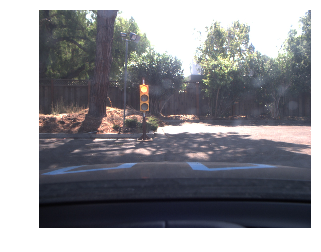

In [26]:
# import the necessary packages
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import cv2
# load the image and convert it from BGR to RGB so that
# we can dispaly it with matplotlib
image = cv2.imread(image_list[500])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
# show our image
plt.figure()
plt.axis("off")
plt.imshow(image)

In [17]:
image = image.reshape((image.shape[0] * image.shape[1], 3))

In [19]:
clt = KMeans(n_clusters = 2)
clt.fit(image)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [20]:
# import the necessary packages
import numpy as np
import cv2
 
def centroid_histogram(clt):
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)

    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()

    # return the histogram
    return hist

In [ ]:

def plot_colors(hist, centroids):
    # initialize the bar chart representing the relative frequency
    # of each of the colors
    bar = np.zeros((50, 300, 3), dtype = "uint8")
    startX = 0

    # loop over the percentage of each cluster and the color of
    # each cluster
    for (percent, color) in zip(hist, centroids):
        # plot the relative percentage of each cluster
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
            color.astype("uint8").tolist(), -1)
        startX = endX

    # return the bar chart
    return bar

In [24]:
# build a histogram of clusters and then create a figure
# representing the number of pixels labeled to each color
hist = utils.centroid_histogram(clt)
bar = utils.plot_colors(hist, clt.cluster_centers_)
 
# show our color bart
plt.figure()
plt.axis("off")
plt.imshow(bar)
plt.show()

AttributeError: 'module' object has no attribute 'centroid_histogram'

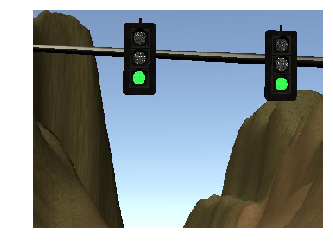

In [91]:
import cv2
import matplotlib.pyplot as plt
image_name = 'image_color_screenshot_06.06.2018.png'
image = cv2.imread(image_name)
temp = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
# show our image
plt.figure()
plt.axis("off")
plt.imshow(temp)

32


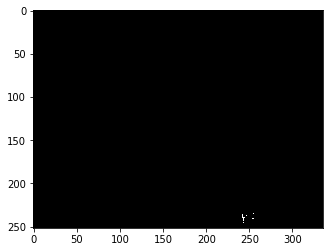

In [92]:
import numpy as np
img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

lower_red = np.array([0,140,120])
upper_red = np.array([50,255,255])
mask0 = cv2.inRange(img_hsv, lower_red, upper_red)
plt.imshow(mask0, cmap='gray')
print np.count_nonzero(mask0)